<a href="https://colab.research.google.com/github/pibieta/ML-course/blob/master/Serasa_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC Taxi Fare 
---
J. P. Ibieta-Jimenez


In [0]:
# imports
import time
import random
import itertools
import datetime as dt
from math import cos, asin, sqrt

# data handling and viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('white')


We will work on the Kaggle competition called *NYC Taxi Fare Prediction*, data can be found [here](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data).  

In [3]:
# Get data
!wget http://fma.if.usp.br/~pibieta/NY_taxi_data/all.zip

--2019-06-14 10:26:41--  http://fma.if.usp.br/~pibieta/NY_taxi_data/all.zip
Resolving fma.if.usp.br (fma.if.usp.br)... 143.107.128.59, 2001:12d0:8020::59
Connecting to fma.if.usp.br (fma.if.usp.br)|143.107.128.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1674618947 (1.6G) [application/zip]
Saving to: ‘all.zip’

all.zip             100%[===================>]   1.56G  5.54MB/s    in 5m 6s   

2019-06-14 10:31:49 (5.22 MB/s) - ‘all.zip’ saved [1674618947/1674618947]



In [4]:
!unzip all.zip
!ls

Archive:  all.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: GCP-Coupons-Instructions.rtf  
all.zip			      sample_data	     test.csv
GCP-Coupons-Instructions.rtf  sample_submission.csv  train.csv


In [0]:
# load data as csv, let's see if Colab can handle this file
# url = 'http://fma.if.usp.br/~pibieta/NY_taxi_data/'

train = pd.read_csv('train.csv', nrows = 5000000, parse_dates=[2])
test = pd.read_csv('test.csv', parse_dates=[1])


# Exploratory Data Analysis and Cleansing
---
The complete `train` file contains around $55 \times 10^6$ rows which difficults the handling. To that intent we can use **part** of the train dataset. However, we must be very careful as to be sure if the sample we choose is representative of the total distribution. The `key` column might give us a hint about the the way the dataset was constructed and in particular about the way the train/test split was generated. This can be useful specially when performing *competitive* analysis.

In [6]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


Now that we have loaded both the train and test datasets as pandas dataframes, we can start looking at data and perform some preliminar analysis.

In particular, we are looking for:
* Null or missing data such as `NaN` values
* Outliers
* Data Leakages


In [0]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000e+06,5.000000e+06,5.000000e+06,4.999964e+06,4.999964e+06,5.000000e+06
mean,1.134080e+01,-7.250678e+01,3.991974e+01,-7.250652e+01,3.991725e+01,1.684695e+00
std,9.820175e+00,1.280970e+01,8.963509e+00,1.284777e+01,9.486767e+00,1.331854e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310364e+03,3.457622e+03,3.345917e+03,2.080000e+02


Above we can already see that:
* the column `fare_amount` has negative values which is weird. This might have to do with errors during Data collection, since we do not have information about the way data was collected, the best may be to eliminate these data points. 

* Also, the `passenger_count` has some weird values, see the max value: $208$. No way a cab can fit 208 people. So we also drop rows with such values.

* Latitude and longitude coordinates for pickup and dropoff seem to have weird values. Visualization will help with this, as we shall see.

In [0]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 670.8 MB


The train file contains data about taxi drives. In particular, it contains an index:
* **key -** Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.

Features: 
* **pickup_datetime -** timestamp value indicating when the taxi ride started.
* **pickup_longitude -** `float` for longitude coordinate of where the taxi ride started.
* **pickup_latitude -** `float` for latitude coordinate of where the taxi ride started.
* **dropoff_longitude -** `float` for longitude coordinate of where the taxi ride ended.
* **dropoff_latitude -** `float` for latitude coordinate of where the taxi ride ended.
* **passenger_count -** `int` indicating the number of passengers in the taxi ride.

And a target value:
* **fare_amount -** `float` dollar amount of the cost of the taxi ride. 


## Time Lapse
Check the time lapse for both the train and test sets. 

In [0]:
print('Train time lapse:')
print('\tstart: {}\n\tstop: {}'.format(train.pickup_datetime.min(),train.pickup_datetime.max()))
print('Test time lapse:')
print('\tstart: {}\n\tstop: {}'.format(test.pickup_datetime.min(),test.pickup_datetime.max()))

Train time lapse:
	start: 2009-01-01 00:00:46+00:00
	stop: 2015-06-30 23:59:03+00:00
Test time lapse:
	start: 2009-01-01 11:04:24+00:00
	stop: 2015-06-30 20:03:50+00:00


Let us compare the time distribution of taxi rides in the train set with those in test set

[]

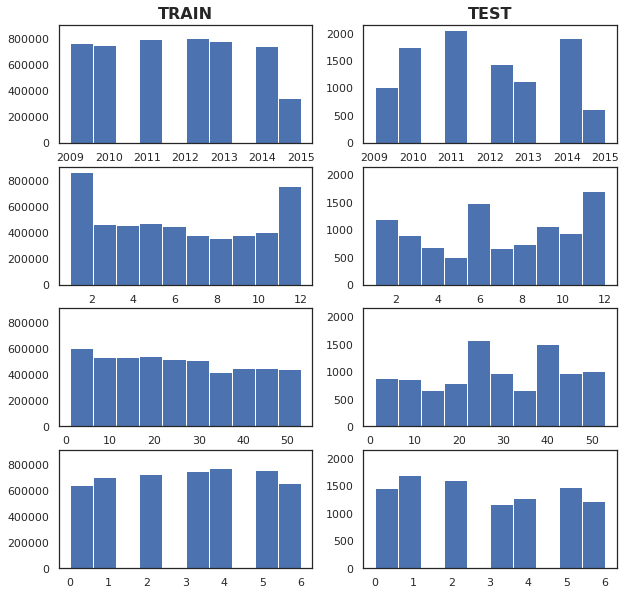

In [143]:
fig, ax = plt.subplots(4,2, figsize=(10,10), sharey= 'col')
ax[0,0].hist(train.pickup_datetime.dt.year)
ax[0,0].set_title('TRAIN', fontweight='bold', fontsize='16')
ax[0,0].set_xlabel('Year', fontweight='bold', fontsize='13')

ax[0,1].hist(test.pickup_datetime.dt.year)
ax[0,1].set_title('TEST', fontweight='bold', fontsize='16')
ax[0,1].set_xlabel('Year', fontweight='bold', fontsize='13')

ax[1,0].hist(train.pickup_datetime.dt.month)
ax[1,0].set_xlabel('Month', fontweight='bold', fontsize='13')


ax[1,1].hist(test.pickup_datetime.dt.month)
ax[2,0].hist(train.pickup_datetime.dt.week)
ax[2,1].hist(test.pickup_datetime.dt.week)
ax[3,0].hist(train.pickup_datetime.dt.dayofweek)
ax[3,1].hist(test.pickup_datetime.dt.dayofweek)
fig.legends

look for NaN values

In [0]:
train.isna().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    36
dropoff_latitude     36
passenger_count       0
dtype: int64

In [0]:
test.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

since missing data has to do with geographic data (and they are so few) we can just drop them

In [81]:
print('Old size: %d' % len(train))
train = train.dropna()
print('New size: %d' % len(train))

Old size: 5000000
New size: 4999964


## Fare_amount
Note that there are some negative values for fare amount. We will pretty much drop them, as well as very absurd positive values, which we set to be any fare >100.



In [0]:
print('fare min: {} USD\nfare max: {} USD\nfare median: {} USD'.format(train.fare_amount.min(), train.fare_amount.max(), train.fare_amount.median()))

fare min: -100.0 USD
fare max: 1273.31 USD
fare median: 8.5 USD


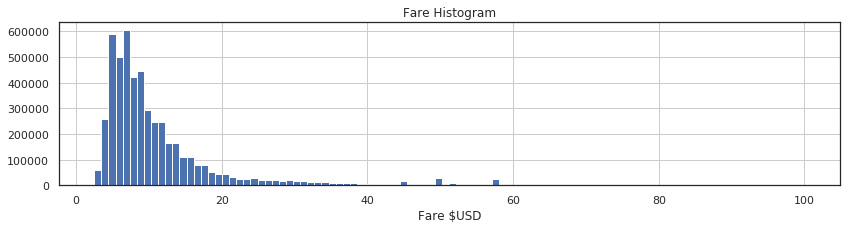

In [0]:
# plot histogram of fare
# train[(train.fare_amount<100)].fare_amount.hist(bins=100, figsize=(14,3))
train[(train.fare_amount<100) & (train.fare_amount> 2.5)].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('Fare $USD')
plt.title('Fare Histogram');

## Geographical data
Let us look at data concerning the positions of pickup and dropoff. We are looking for any weird values such as NaNs, or locations that do not correspond to the NY area.

We can also take a look at the histogram of pickups and dropoff locations. This will give us an idea on how to filter data for the modeling part.

By trying to plot a simple histogram of the `pickup_latitude` column we see that most of the values are concentred in a small region. More precisely, there are latitude values way off the ones for NY. 
To see this more carefully we plot several histograms (already focusing in the region of interest) that compare the train and test datasets. 



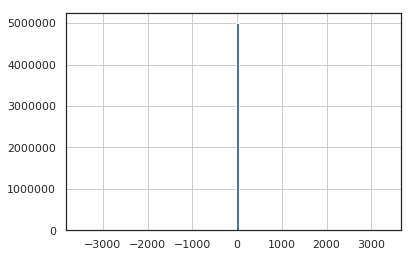

In [0]:
train.pickup_latitude.hist(bins=100)

[]

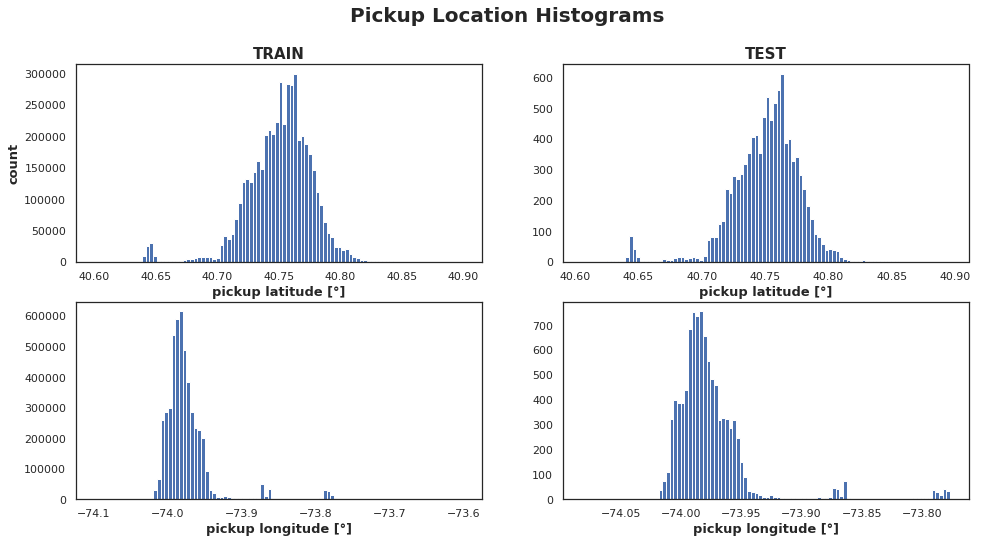

In [0]:
fig, ax = plt.subplots(2,2, figsize=(16,8))
# fig.tight_layout() 
fig.suptitle('Pickup Location Histograms', fontweight = 'bold', fontsize='20')
ax[0,0].hist(train.pickup_latitude[(train.pickup_latitude> 40.6) & (train.pickup_latitude< 40.9)], bins =100)
ax[0,0].set_title('TRAIN', fontweight='bold', fontsize='15')
ax[0,0].set_xlabel('pickup latitude [°]', fontweight='bold', fontsize='13')
ax[0,0].set_ylabel('count', fontweight='bold', fontsize='13')

ax[0,1].hist(test.pickup_latitude[(test.pickup_latitude> 40.6) & (test.pickup_latitude< 40.9)], bins =100)
ax[0,1].set_xlabel('pickup latitude [°]', fontweight='bold', fontsize='13')
ax[0,1].set_title('TEST', fontweight='bold', fontsize='15')

ax[1,0].hist(train.pickup_longitude[(train.pickup_longitude> -74.1) & (train.pickup_longitude<-73.6)], bins =100)
ax[1,0].set_xlabel('pickup longitude [°]', fontweight='bold', fontsize='13')
# ax[1,0].set_ylabel('count', fontweight='bold', fontsize='13')

# ax[0,1].set_ylabel('count', fontweight='bold', fontsize='13')
ax[1,1].hist(test.pickup_longitude[(test.pickup_longitude> -74.1) & (test.pickup_longitude<-73.6)], bins =100)
ax[1,1].set_xlabel('pickup longitude [°]', fontweight='bold', fontsize='13')
# ax[1,1].set_ylabel('count', fontweight='bold', fontsize='13')
fig.legends

Both distributions seem very similar. This strongly suggests that the dataset was randomly shuffled before performing the train/test split. By having a shuffled train set, we can sample the dataset without losing too much information about the whole population statistics. This is, we can use less data and hope to have a good representative of the entire dataset. This is important since the entire dataset is difficult to handle, as a consequence to perform Feat. Engineering would be very costly.

[]

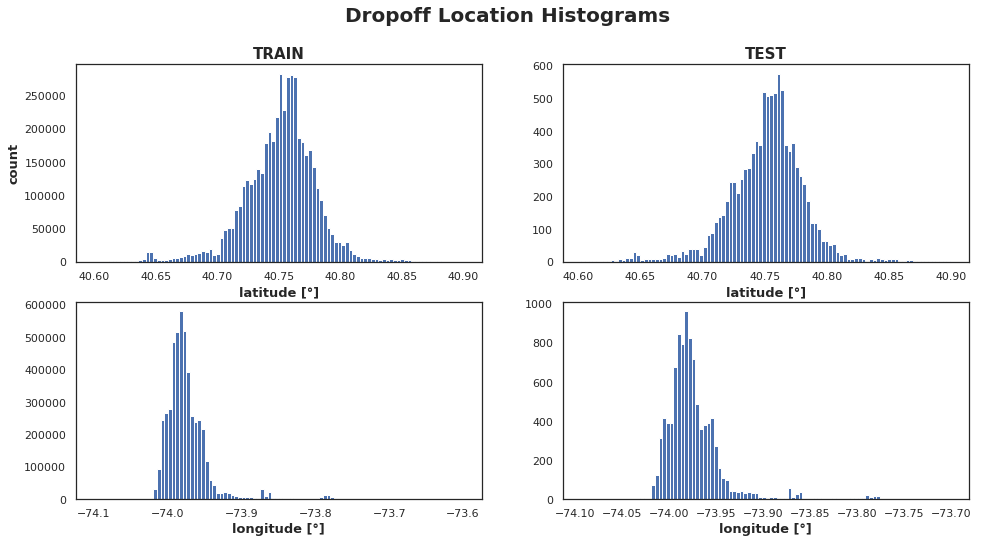

In [0]:
fig, ax = plt.subplots(2,2, figsize=(16,8))
# fig.tight_layout() 
fig.suptitle('Dropoff Location Histograms', fontweight = 'bold', fontsize='20')
ax[0,0].hist(train.dropoff_latitude[(train.dropoff_latitude> 40.6) & (train.dropoff_latitude< 40.9)], bins =100)
ax[0,0].set_title('TRAIN', fontweight='bold', fontsize='15')
ax[0,0].set_xlabel('latitude [°]', fontweight='bold', fontsize='13')
ax[0,0].set_ylabel('count', fontweight='bold', fontsize='13')

ax[0,1].hist(test.dropoff_latitude[(test.dropoff_latitude> 40.6) & (test.dropoff_latitude< 40.9)], bins =100)
ax[0,1].set_xlabel('latitude [°]', fontweight='bold', fontsize='13')
ax[0,1].set_title('TEST', fontweight='bold', fontsize='15')

ax[1,0].hist(train.dropoff_longitude[(train.dropoff_longitude> -74.1) & (train.dropoff_longitude<-73.6)], bins =100)
ax[1,0].set_xlabel('longitude [°]', fontweight='bold', fontsize='13')
# ax[1,0].set_ylabel('count', fontweight='bold', fontsize='13')

# ax[0,1].set_ylabel('count', fontweight='bold', fontsize='13')
ax[1,1].hist(test.dropoff_longitude[(test.dropoff_longitude> -74.1) & (test.dropoff_longitude<-73.6)], bins =100)
ax[1,1].set_xlabel('longitude [°]', fontweight='bold', fontsize='13')
# ax[1,1].set_ylabel('count', fontweight='bold', fontsize='13')
fig.legends

Finally, to handle the values that do not correspond to the NY area, we will use the min and max values in the test set, in that way we do not throw everything off. This could be considered a data leakage.

In [82]:
# minimum and maximum longitude test set
long_bb = min(test.pickup_longitude.min(), test.dropoff_longitude.min()),max(test.pickup_longitude.max(), test.dropoff_longitude.max())
# minimum and maximum latitude test
lat_bb = min(test.pickup_latitude.min(), test.dropoff_latitude.min()), max(test.pickup_latitude.max(), test.dropoff_latitude.max())
BB = long_bb + lat_bb
BB

(-74.263242, -72.986532, 40.568973, 41.709555)

We will use the above Bounding Box to select relevant data only.

## Passenger_count
Let us look at the feature that counts the number of passengers at each ride. The max value is non-sense. Also, rides with 0 passengers should not be considered.

In [0]:
print('passenger min: {}\npassenger max: {}\npassenger median: {}'.format(train.passenger_count.min(), train.passenger_count.max(), train.passenger_count.median()))

passenger min: 0
passenger max: 208
passenger median: 1.0


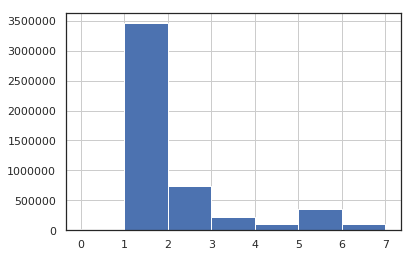

In [0]:
train[train.passenger_count <= 7].passenger_count.hist(bins =7)

## The cut
Considering all the above insights on data, we perform a **cut** in the train file, as follows:

In [83]:
train_cut = train[((train.pickup_longitude >= BB[0]) & (train.pickup_longitude <= BB[1])) 
         & ((train.pickup_latitude >= BB[2]) & (train.pickup_latitude <= BB[3])) 
         & ((train.dropoff_longitude >= BB[0]) & (train.dropoff_longitude <= BB[1])) 
         & ((train.dropoff_latitude >= BB[2]) & (train.dropoff_latitude <= BB[3])) 
         & (train.fare_amount > 2.5) & (train.passenger_count > 0) & (train.passenger_count < 7)] #& (train.distance > 0.2)]
print('Proportion of Data lost: {0:.3f}%'.format( (train.shape[0] - train_cut.shape[0])/ train.shape[0] * 100))

Proportion of Data lost: 2.849%


# Feature Engineering
---
In this section we intend to expand our dataset by adding aritificial features. This can be done in many ways (for this particular dataset), and ultimately dependes on the creativity and prior knowledge of the DS. In this case, we will not perform a very sophisticated process, but rather something simple that cann enrich our dataset. 

As an starting point we consider:
*  *manhattan* (L1-norm) distance between pickup and dropoff
* pickup hour (bucketized)
* weekday --> one hot encoded

For later:
* direction of the trip (E-W and N-S)
* grid position on the map (you could use a 10x10 grid)
* Holidays
* From airport / To airport (for fixed fare trips)

In [0]:
#calculating the distance between the two points (pickup and dropoff) in km
def distance(lat1, lon1, lat2, lon2, norm = 1):
  '''
    Calculates the distance between two points: (lat1,lon1) and (lat2,lon2)
    norm: 1 --> 'Manhattan'
          2 --> 'geodesic'
  '''
  if norm == 1:
    distance = np.abs(lat2 - lat1) + np.abs(lon2 - lon1)
  elif norm == 2:
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    distance = 12742 * asin(sqrt(a)) #2*R*asin
  return distance 

  

In [0]:
def add_feats(df, norm = 1):
  '''
  Input:  pandas dataframe
  Output: dataframe with added features
  '''
  df['distance'] = df.apply(lambda row: distance(row.pickup_latitude, row.pickup_longitude, row.dropoff_latitude, row.dropoff_longitude, norm ), axis =1)
  df['hour'] = df.pickup_datetime.dt.hour
#   df['day'] = df.pickup_datetime.dt.day
#   df['month'] = df.pickup_datetime.dt.month
#   df['weekday'] = df.pickup_datetime.dt.weekday
  weekday =pd.get_dummies(train.pickup_datetime.dt.weekday)
  weekday.columns = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
  df = pd.concat([df,weekday], axis = 1)
  return df

In [100]:
# it takes around 11 min for 5M rows
start_time = time.time()
train_cut = add_feats(train, 2)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1064.8128077983856 seconds ---


Save this dataframe as a pickle file so we can load it later, and save computation time.

In [0]:
train_cut.to_pickle('./train_cut_L2.pkl')

In [91]:
train_cut.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour,mon,tue,wed,thu,fri,sat,sun
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.011742,17,1,0,0,0,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,0.107481,16,0,1,0,0,0,0,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.019212,0,0,0,0,1,0,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,0.029386,4,0,0,0,0,0,1,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,0.027194,7,0,1,0,0,0,0,0


## Train/Validation split
We will split the train set into two datasets: Train and validation

The given test dataset will be held out for final scoring.

In [0]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

In [0]:
cols = [ 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance', 'hour', 'weekday']
X_train, X_test, y_train, y_test = train_test_split(train_cut.drop('fare_amount', axis=1)[cols],
                                                    train_cut['fare_amount'], test_size=0.20)

# Modeling
---
In this section we start the construction of simple models for fare prediction.

## Base Model (Benchmarking)

We will start with a linear model for a starter. This will serve as a benchmark model to compare the performance of more complex models

In [0]:
train_cut['weekday'] = train_cut.pickup_datetime.dt.weekday

In [114]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour,weekday
3458918,-73.976360,40.753448,-74.003391,40.732549,2,3.253652,22,2
4962324,-73.993513,40.741495,-74.006733,40.741655,1,1.113901,19,5
2574121,-73.870775,40.773650,-74.009416,40.706789,1,13.845819,3,0
3945128,-73.991409,40.735626,-74.011230,40.708382,1,3.459451,11,1
1590270,-73.991529,40.749860,-73.991121,40.770688,1,2.316223,10,1


In [0]:
lin_model = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))
lin_model.fit(X_train, y_train)

y_train_pred = lin_model.predict(X_train)
y_test_pred = lin_model.predict(X_test)

We use the RMSE score for validation of our model (Kaggle)


In [113]:
print('LINEAR MODEL --- RMSE scores\ntrain: {}\ntest: {}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred)),
np.sqrt(mean_squared_error(y_test, y_test_pred))))


LINEAR MODEL --- RMSE scores
train: 9.806074284620877
test: 9.84650117505267


## Gradient Boosting Decision Trees (XGBoost)
Next, we construct a Boosted Decision Tree model together with Bayesian Optimization

In [116]:
!pip install bayesian-optimization


  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

from bayes_opt import BayesianOptimization

def plot_features(booster, figsize):    
  fig, ax = plt.subplots(1,1,figsize=figsize)
  return plot_importance(booster=booster, ax=ax)



In [118]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
def xgb_evaluate(max_depth, gamma, colsample_bytree):
  params = {'eval_metric': 'rmse',
            'max_depth': int(max_depth),
            'subsample': 0.8,
            'eta': 0.1,
            'gamma': gamma,
            'colsample_bytree': colsample_bytree}
  cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    

  # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
  return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [0]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')

|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
|  1        | -3.97     |  0.8151   |  0.9148   |  6.709    |
|  2        | -3.97     |  0.8      |  0.1779   |  6.323    |
|  3        | -4.394    |  0.3178   |  0.3039   |  3.25     |
|  4        | -3.923    |  0.9      |  0.0      |  7.0      |
|  5        | -4.122    |  0.3      |  0.0      |  7.0      |
|  6        | -3.924    |  0.9      |  0.3653   |  7.0      |
|  7        | -3.966    |  0.9      |  0.03096  |  6.961    |
|  8        | -4.009    |  0.9      |  0.4404   |  5.198    |


In [0]:
params = {'max_depth': 7.0, 'gamma': 0.001,  'max_delta_step': 10.0, 'subsample': 0.4, 'colsample_bytree': 0.9}
params['max_depth'] = int(params['max_depth'])


In [120]:
start_time = time.time()
# Train a model with the hyperparameters we obtained in the search
model_xgb = xgb.train(params, dtrain, num_boost_round=250)
print("--- %s seconds ---" % (time.time() - start_time))

# Predict on testing and training set
y_pred_xgb = model_xgb.predict(dtest)
y_train_pred_xgb = model_xgb.predict(dtrain)

# Report testing and training RMSE
print('RMSE test: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_xgb))))
print('RMSE train: {}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))))

RMSE test: 4.617233646075735
RMSE train: 4.212636032244176


The F-score sums up the number of times a given feature is split. Comparing this quantity for each feature is usually interpreted as a *Feature Importance* plot.

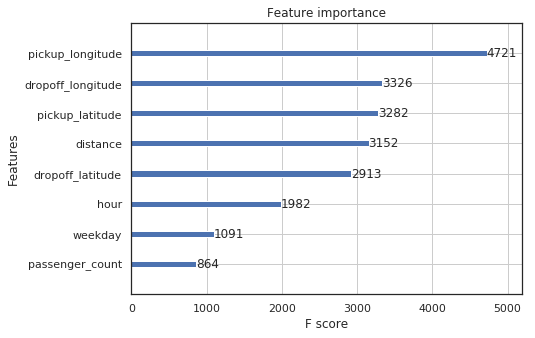

In [121]:
plot_features(model_xgb, (7,5))


## DNN Regressor

In [0]:
# 